In [1]:
#importing the needed libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import loguniform
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, RandomizedSearchCV,RepeatedStratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score, f1_score,roc_auc_score,roc_curve,classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

In [2]:
# The business problem is to predict the 5-Year Career Longevity for NBA Rookies
# the target y = 0 if career years played < 5
# the target y = 1 if career years played >= 5

In [3]:
#reading the data
nba_data_df = pd.read_csv("nba_logreg.csv")
print(nba_data_df.shape) #there are 1340 rows and 21 attributes

(1340, 21)


In [4]:
#checking the top few rows
nba_data_df.head()

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0


In [5]:
#converting the target variable to integer type
nba_data_df = nba_data_df.astype({'TARGET_5Yrs': int}) 
print(nba_data_df.dtypes) 
print(nba_data_df.head())

Name            object
GP               int64
MIN            float64
PTS            float64
FGM            float64
FGA            float64
FG%            float64
3P Made        float64
3PA            float64
3P%            float64
FTM            float64
FTA            float64
FT%            float64
OREB           float64
DREB           float64
REB            float64
AST            float64
STL            float64
BLK            float64
TOV            float64
TARGET_5Yrs      int32
dtype: object
              Name  GP   MIN  PTS  FGM  FGA   FG%  3P Made  3PA   3P%  ...  \
0   Brandon Ingram  36  27.4  7.4  2.6  7.6  34.7      0.5  2.1  25.0  ...   
1  Andrew Harrison  35  26.9  7.2  2.0  6.7  29.6      0.7  2.8  23.5  ...   
2   JaKarr Sampson  74  15.3  5.2  2.0  4.7  42.2      0.4  1.7  24.4  ...   
3      Malik Sealy  58  11.6  5.7  2.3  5.5  42.6      0.1  0.5  22.6  ...   
4      Matt Geiger  48  11.5  4.5  1.6  3.0  52.4      0.0  0.1   0.0  ...   

   FTA   FT%  OREB  DREB  REB  AST

In [6]:
#checking for null columns
nba_data_df.isnull().sum()/len(nba_data_df)*100
#3P% feature column is having null values since few rows hence we can drop them

Name           0.000000
GP             0.000000
MIN            0.000000
PTS            0.000000
FGM            0.000000
FGA            0.000000
FG%            0.000000
3P Made        0.000000
3PA            0.000000
3P%            0.820896
FTM            0.000000
FTA            0.000000
FT%            0.000000
OREB           0.000000
DREB           0.000000
REB            0.000000
AST            0.000000
STL            0.000000
BLK            0.000000
TOV            0.000000
TARGET_5Yrs    0.000000
dtype: float64

In [7]:
# we drop the rows with the null columns
nba_data_df = nba_data_df.dropna()
#resetting the index
nba_data_df = nba_data_df.reset_index(drop=True)
# any null columns
nba_data_df.isnull().sum()

Name           0
GP             0
MIN            0
PTS            0
FGM            0
FGA            0
FG%            0
3P Made        0
3PA            0
3P%            0
FTM            0
FTA            0
FT%            0
OREB           0
DREB           0
REB            0
AST            0
STL            0
BLK            0
TOV            0
TARGET_5Yrs    0
dtype: int64

In [8]:
#renaming the columns
nba_data_df.rename(columns = {'GP':'GamesPlayed', 'MIN':'MinutesPlayed', 'PTS':'PointsPerGame','FGM':'FieldGoalsMade',
                             'FGA':'FieldGoalAttempts','FG%':'FieldGoalPercent','3P Made':'ThreePointMade',
                              '3PA':'ThreePointAttempts',
                             '3P%':'ThreePointPercent','FTM':'FreeThrowMade','FTA':'FreeThrowAttempt',
                              'FT%':'FreeThrowPercent',
                             'OREB':'OffensiveRebounds','DREB':'DefensiveRebounds',
                              'REB':'rebounds','AST':'Assists',
                             'STL':'Steals','BLK':'Blocks','TOV':'Turnovers','TARGET_5Yrs':'TargetFiveYears'}, inplace = True) 

In [9]:
nba_data_df.head()

,Name,GamesPlayed,MinutesPlayed,PointsPerGame,FieldGoalsMade,FieldGoalAttempts,FieldGoalPercent,ThreePointMade,ThreePointAttempts,ThreePointPercent,...,FreeThrowAttempt,FreeThrowPercent,OffensiveRebounds,DefensiveRebounds,rebounds,Assists,Steals,Blocks,Turnovers,TargetFiveYears
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1


In [10]:
nba_data_df.columns

Index(['Name', 'GamesPlayed', 'MinutesPlayed', 'PointsPerGame',
       'FieldGoalsMade', 'FieldGoalAttempts', 'FieldGoalPercent',
       'ThreePointMade', 'ThreePointAttempts', 'ThreePointPercent',
       'FreeThrowMade', 'FreeThrowAttempt', 'FreeThrowPercent',
       'OffensiveRebounds', 'DefensiveRebounds', 'rebounds', 'Assists',
       'Steals', 'Blocks', 'Turnovers', 'TargetFiveYears'],
      dtype='object')

In [11]:
nba_data_df.shape

(1329, 21)

In [12]:
# the target column is "TargetFiveYears"
# there are 826 players having career length more then 5 years and 503 players having career length less then 5
nba_data_df.TargetFiveYears.value_counts()

1    826
0    503
Name: TargetFiveYears, dtype: int64

<AxesSubplot:>

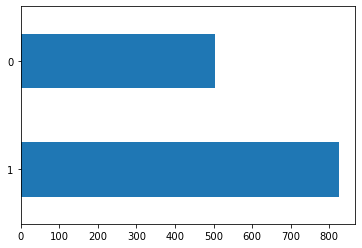

In [13]:
#the horizontal bar plot
nba_data_df.TargetFiveYears.value_counts().plot(kind='barh')

<AxesSubplot:xlabel='TargetFiveYears', ylabel='GamesPlayed'>

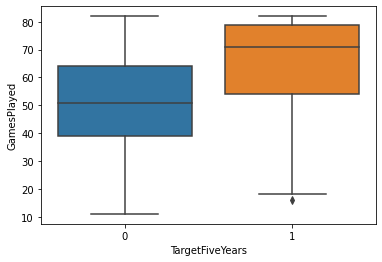

In [14]:
#boxplot to visualize the number of career years and the number of games played.
# the more the years played, more is the number of games played
sns.boxplot(x='TargetFiveYears',
y='GamesPlayed', data=nba_data_df)

<AxesSubplot:xlabel='TargetFiveYears', ylabel='MinutesPlayed'>

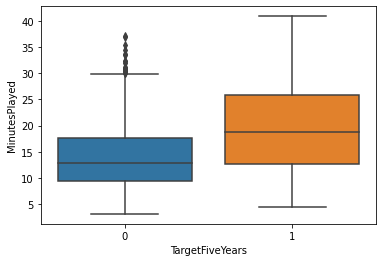

In [15]:
#boxplot to visualize the number of career years and the minutes played
#more the number of years played, the more is the minutes played
sns.boxplot(x='TargetFiveYears',
y='MinutesPlayed', data=nba_data_df)

<AxesSubplot:xlabel='TargetFiveYears', ylabel='PointsPerGame'>

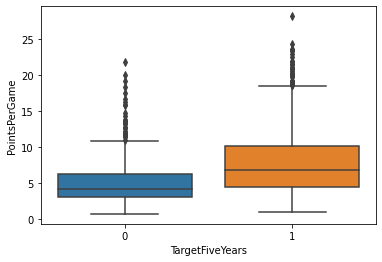

In [16]:
#boxplot to visualiza the pointspergame and number of career years
#the more the number of years played, the more the points per game
sns.boxplot(x='TargetFiveYears',
y='PointsPerGame', data=nba_data_df)

Text(0, 0.5, 'Minutes Played')

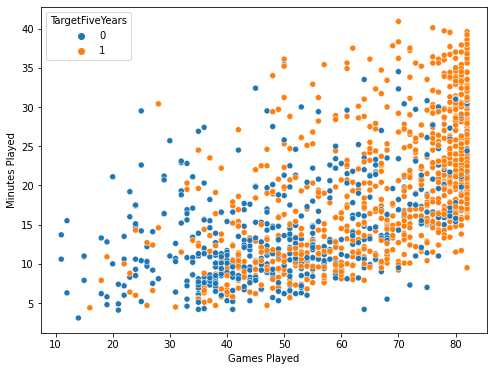

In [17]:
plt.figure(figsize=(8,6))
sns.scatterplot(x="GamesPlayed", y="MinutesPlayed", hue="TargetFiveYears",data=nba_data_df)
plt.xlabel("Games Played")
plt.ylabel("Minutes Played")
# can clearly see the correlation and the degree of collinearity will find from the correlation matrix

Text(0, 0.5, 'Points per Game')

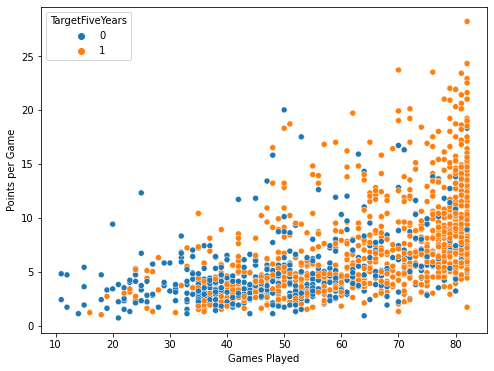

In [18]:
# can clearly see the correlation and the degree of collinearity will find from the correlation matrix
plt.figure(figsize=(8,6))
sns.scatterplot(x="GamesPlayed", y="PointsPerGame", hue="TargetFiveYears",data=nba_data_df)
plt.xlabel("Games Played")
plt.ylabel("Points per Game")

Text(0, 0.5, 'Points per Game')

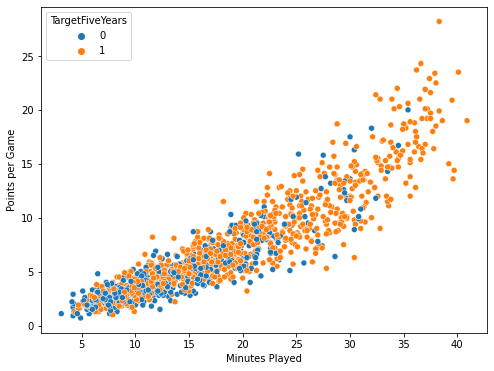

In [19]:
plt.figure(figsize=(8,6))
sns.scatterplot(x="MinutesPlayed", y="PointsPerGame", hue="TargetFiveYears",data=nba_data_df)
plt.xlabel("Minutes Played")
plt.ylabel("Points per Game")
# can clearly see the correlation and the degree of collinearity will find from the correlation matrix

Text(0, 0.5, 'DefensiveRebounds')

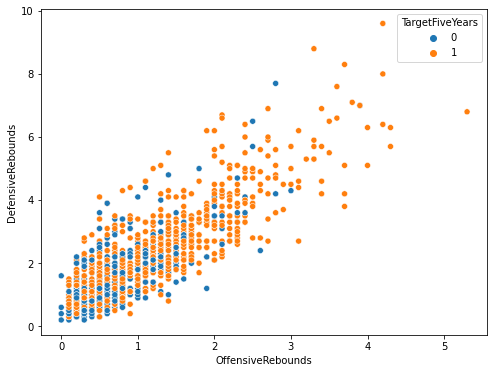

In [20]:
plt.figure(figsize=(8,6))
sns.scatterplot(x="OffensiveRebounds", y="DefensiveRebounds", hue="TargetFiveYears",data=nba_data_df)
plt.xlabel("OffensiveRebounds")
plt.ylabel("DefensiveRebounds")
# can clearly see the correlation and the degree of collinearity will find from the correlation matrix

<AxesSubplot:xlabel='TargetFiveYears', ylabel='FreeThrowMade'>

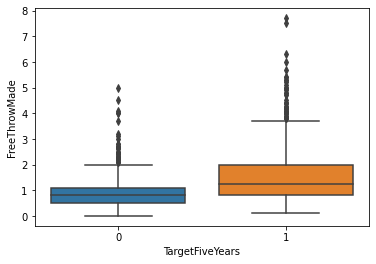

In [21]:
#boxplot to visualize Freethrowmade and the number of career years
#the more the number of years played, the more the free throw made
sns.boxplot(x='TargetFiveYears',
y='FreeThrowMade', data=nba_data_df)

<AxesSubplot:xlabel='TargetFiveYears', ylabel='Turnovers'>

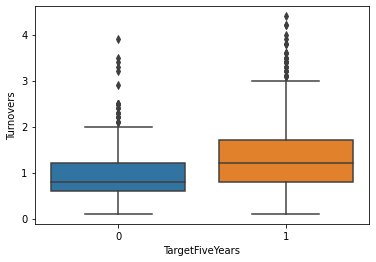

In [22]:
#boxplot to visualize the turnovers and the number of career years
#the more the number of years played, the more the turnovers
sns.boxplot(x='TargetFiveYears',
y='Turnovers', data=nba_data_df)

In [23]:
#correlation matrix to view the pairwise correlation among the predictors
columns = ['GamesPlayed', 'MinutesPlayed', 'PointsPerGame',
'FieldGoalsMade', 'FieldGoalAttempts', 'FieldGoalPercent', 'ThreePointMade',
'ThreePointAttempts', 'ThreePointPercent', 'FreeThrowMade', 'FreeThrowAttempt',
'FreeThrowPercent', 'OffensiveRebounds', 'DefensiveRebounds',
'rebounds', 'Assists', 'Steals', 'Blocks', 'Turnovers']
X=nba_data_df[columns]
correlationMat = X.corr()
corrPairs = correlationMat.unstack()

In [24]:
ordPairs = corrPairs.sort_values(kind="quicksort").drop_duplicates()
positivePairs = ordPairs[ordPairs >0.8 ]
positivePairs = positivePairs[ordPairs <1 ]
print(positivePairs)
# above scatterplot of PointsPerGame and MinutesPlayed showed high collinearity
# and in the below pairwise plot, we can see the value is
# "PointsPerGame       MinutesPlayed        0.911746"

Turnovers           FreeThrowMade        0.804762
FieldGoalAttempts   FreeThrowAttempt     0.805507
FreeThrowMade       FieldGoalAttempts    0.826244
MinutesPlayed       Turnovers            0.826431
FieldGoalsMade      Turnovers            0.834343
OffensiveRebounds   DefensiveRebounds    0.838904
FieldGoalsMade      FreeThrowAttempt     0.840667
Turnovers           FieldGoalAttempts    0.845952
FreeThrowMade       FieldGoalsMade       0.848146
Turnovers           PointsPerGame        0.850272
FreeThrowAttempt    PointsPerGame        0.880826
PointsPerGame       FreeThrowMade        0.896245
MinutesPlayed       FieldGoalsMade       0.902864
FieldGoalAttempts   MinutesPlayed        0.910194
PointsPerGame       MinutesPlayed        0.911746
OffensiveRebounds   rebounds             0.932874
rebounds            DefensiveRebounds    0.978199
FieldGoalAttempts   PointsPerGame        0.979676
FieldGoalsMade      FieldGoalAttempts    0.980117
FreeThrowMade       FreeThrowAttempt     0.980626


In [25]:
negative_pairs = ordPairs[ordPairs < -0.5]
print(negative_pairs)

Series([], dtype: float64)


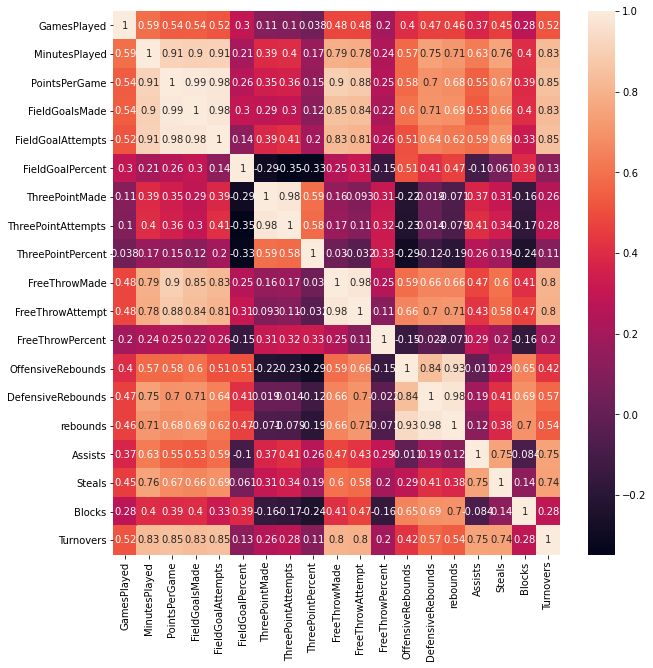

In [26]:
#correlation matrix heatmap
plt.rcParams["figure.figsize"]=10,10
sns.heatmap(X.corr(), annot=True)
plt.show()

In [27]:
# creating a function to print the confusion matrix, accuracy, precision, recall and classification report
def metrics_display_func(y_test,y_pred):
   conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred) 
   print(conf_mat)
   conf_df = pd.DataFrame(conf_mat, columns=np.unique(y_test), index = np.unique(y_test))
   conf_df.index.name = 'Actual'
   conf_df.columns.name = 'Predicted'
   plt.figure(figsize = (5,5))
   sns.set(font_scale=1.4)
   sns.heatmap(conf_df, cmap="Greens", fmt='d',annot=True)
   print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred))
   print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
   print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
   print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))
   print("               CLASSIFICATION REPORT      ")
   print(classification_report(y_test, y_pred))

In [28]:
# Step1: Setting up the business objective
# Step2: Reading the dataset
# Step3: Data analysis and preprocessing
# Step4: Exploratory Data Analysis
# All these step done
# Next steps will do the following
# Feature selection
# Model training
# Model Testing
# Metrics
# Cross validation and Grid Search for hyperparameter tuning
# Final model selection

[[ 72  86]
 [ 35 206]]
Accuracy: 0.697
Precision: 0.705
Recall: 0.855
F1: 0.773
               CLASSIFICATION REPORT      
              precision    recall  f1-score   support

           0       0.67      0.46      0.54       158
           1       0.71      0.85      0.77       241

    accuracy                           0.70       399
   macro avg       0.69      0.66      0.66       399
weighted avg       0.69      0.70      0.68       399



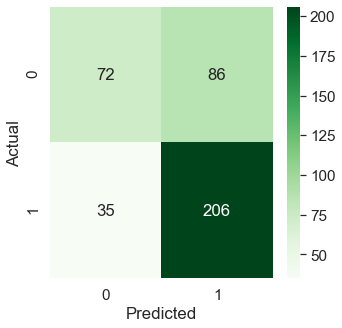

In [29]:
# with all the available features, will train and test the logistic regression model
columns = ['GamesPlayed', 'MinutesPlayed', 'PointsPerGame',
'FieldGoalsMade', 'FieldGoalAttempts', 'FieldGoalPercent', 'ThreePointMade',
'ThreePointAttempts', 'ThreePointPercent', 'FreeThrowMade', 'FreeThrowAttempt',
'FreeThrowPercent', 'OffensiveRebounds', 'DefensiveRebounds',
'rebounds', 'Assists', 'Steals', 'Blocks', 'Turnovers']
X=nba_data_df[columns]
y=nba_data_df['TargetFiveYears']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
modellr=LogisticRegression()
modellr.fit(X_train,y_train)
y_pred=modellr.predict(X_test)
metrics_display_func(y_test,y_pred)

In [30]:
## 72 correctly classified in the class 0 and 206 correctly classified in the class 1

In [31]:
#### FEATURE SELECTION####

In [32]:
# Using the Sklearn SelectFromModel class for features selection 
# where features having values greater than a certain specified value
# leaving the threshold value to the default value only
columns = ['GamesPlayed', 'MinutesPlayed', 'PointsPerGame',
'FieldGoalsMade', 'FieldGoalAttempts', 'FieldGoalPercent', 'ThreePointMade',
'ThreePointAttempts', 'ThreePointPercent', 'FreeThrowMade', 'FreeThrowAttempt',
'FreeThrowPercent', 'OffensiveRebounds', 'DefensiveRebounds',
'rebounds', 'Assists', 'Steals', 'Blocks', 'Turnovers']
X=nba_data_df[columns]
y=nba_data_df['TargetFiveYears']
sfmod = SelectFromModel(modellr,max_features=6)
sfmod.fit(X,y)
feature_idx = sfmod.get_support()
feature_name =X.columns[feature_idx]
feature_name

Index(['PointsPerGame', 'FieldGoalAttempts', 'FreeThrowAttempt',
       'OffensiveRebounds', 'Blocks', 'Turnovers'],
      dtype='object')

[[ 72  86]
 [ 37 204]]
Accuracy: 0.692
Precision: 0.703
Recall: 0.846
F1: 0.768
               CLASSIFICATION REPORT      
              precision    recall  f1-score   support

           0       0.66      0.46      0.54       158
           1       0.70      0.85      0.77       241

    accuracy                           0.69       399
   macro avg       0.68      0.65      0.65       399
weighted avg       0.69      0.69      0.68       399



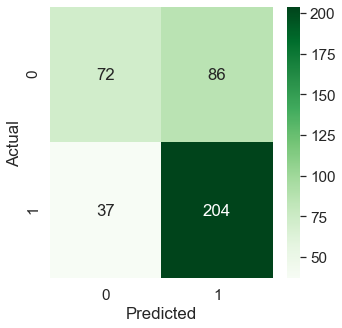

In [33]:
## keeping only the features returned from the above selection method
columns = ['PointsPerGame', 'FieldGoalAttempts', 'FreeThrowAttempt',
       'OffensiveRebounds', 'Blocks','Turnovers']
X=nba_data_df[columns]
y=nba_data_df['TargetFiveYears']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
modellr=LogisticRegression()
modellr.fit(X_train,y_train)
y_pred=modellr.predict(X_test)
metrics_display_func(y_test,y_pred)

In [34]:
#Feature selection using Regularization LassoCV
columns = ['GamesPlayed', 'MinutesPlayed', 'PointsPerGame',
'FieldGoalsMade', 'FieldGoalAttempts', 'FieldGoalPercent', 'ThreePointMade',
'ThreePointAttempts', 'ThreePointPercent', 'FreeThrowMade', 'FreeThrowAttempt',
'FreeThrowPercent', 'OffensiveRebounds', 'DefensiveRebounds',
'rebounds', 'Assists', 'Steals', 'Blocks', 'Turnovers']
X=nba_data_df[columns]
y=nba_data_df['TargetFiveYears']
modlasso = LassoCV().fit(X, y)
importance = np.abs(lasso.coef_)
feature_names = np.array(columns)
#print(feature_names)
importantFeatures = np.array(feature_names[importance != 0])
#print(importantFeatures)
importance = importance[importance != 0]
#print(importance)
plt.figure(figsize = (20,5))
plt.bar(height=importance, x=importantFeatures)
plt.title("Important Features")
plt.show()

NameError: name 'lasso' is not defined

[[ 81  77]
 [ 34 207]]
Accuracy: 0.722
Precision: 0.729
Recall: 0.859
F1: 0.789
               CLASSIFICATION REPORT      
              precision    recall  f1-score   support

           0       0.70      0.51      0.59       158
           1       0.73      0.86      0.79       241

    accuracy                           0.72       399
   macro avg       0.72      0.69      0.69       399
weighted avg       0.72      0.72      0.71       399



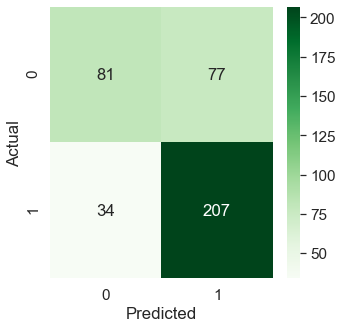

In [35]:
## keeping only the features returned from the above selection method
columns = ['OffensiveRebounds','FieldGoalPercent','GamesPlayed',
           'Assists','PointsPerGame','FreeThrowPercent','ThreePointPercent'
          ]
X=nba_data_df[columns]
y=nba_data_df['TargetFiveYears']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
modellr=LogisticRegression()
modellr.fit(X_train,y_train)
y_pred=modellr.predict(X_test)
metrics_display_func(y_test,y_pred)

In [36]:
seed=99


In [37]:
# five fold cross validation
kfold = KFold(n_splits=5,random_state=seed)
modellr = LogisticRegression()
results = cross_val_score(modellr,X,y,cv=kfold)
print(results)
print("Accuracy: ",results.mean()*100)

[0.65789474 0.73684211 0.7481203  0.69548872 0.69811321]
Accuracy:  70.72918144417649


In [38]:
#Grid search CV
modellr = LogisticRegression()
penalty = ["l1","l2"] # Regularization l1 is Lasso and L2 is Ridge
C = [0,1,2,3,4,5,6,7,8,9,10,20]
hyperparameters=dict(C=C,penalty=penalty)

In [39]:
clf = GridSearchCV(modellr,hyperparameters,cv=5)
optModel = clf.fit(X,y)
optModel.best_estimator_.get_params()

{'C': 10,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [40]:
kfold = KFold(n_splits=5,random_state=seed)
modellr = LogisticRegression(C=10, penalty="l2")
results = cross_val_score(modellr,X,y,cv=kfold)
print(results)
print("Accuracy: ",results.mean()*100)

[0.65789474 0.72556391 0.7481203  0.69548872 0.69433962]
Accuracy:  70.42814583628883


In [41]:
C=loguniform(1e-5, 100)
penalty = ["l1","l2"] # Regularization l1 is Lasso and L2 is Ridge
hyperparameters=dict(C=C,penalty=penalty)

In [42]:
randomSearchCV = RandomizedSearchCV(modellr,hyperparameters,n_iter=500,random_state=seed,n_jobs=-1)

In [43]:
randomSearchCV.fit(X,y)
print(randomSearchCV.best_params_)
print(randomSearchCV.best_score_)

{'C': 10.071178963628377, 'penalty': 'l2'}
0.7230869626897433


In [48]:
RSkfold = RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=seed)
modellr = LogisticRegression(C=10.07, penalty="l2")
results = cross_val_score(modellr,X,y,cv=RSkfold)
print(results)
print("Accuracy: ",results.mean()*100)

[0.70676692 0.70676692 0.69924812 0.70676692 0.78195489 0.68421053
 0.67669173 0.72180451 0.73684211 0.75       0.7593985  0.66165414
 0.73684211 0.72180451 0.73684211 0.69172932 0.68421053 0.7443609
 0.72180451 0.63636364 0.69924812 0.66165414 0.70676692 0.7443609
 0.66165414 0.76691729 0.63157895 0.70676692 0.7593985  0.73484848]
Accuracy:  71.13085744664693


In [50]:
#with the Random grid search , the accuracy achieved is 71.13%

[[ 82  76]
 [ 34 207]]
Accuracy: 0.724
Precision: 0.731
Recall: 0.859
F1: 0.790
               CLASSIFICATION REPORT      
              precision    recall  f1-score   support

           0       0.71      0.52      0.60       158
           1       0.73      0.86      0.79       241

    accuracy                           0.72       399
   macro avg       0.72      0.69      0.69       399
weighted avg       0.72      0.72      0.71       399



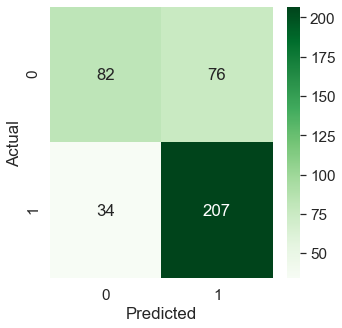

In [51]:
modellr.fit(X_train,y_train)
y_pred=modellr.predict(X_test)
metrics_display_func(y_test,y_pred)

In [52]:
#82 class 0 correctly classified and 207 class 1 observations correctly classified

In [55]:
# fetching the predicted probabilities
yProbs = modellr.predict_proba(X_test)[:,1]

In [57]:
# true positive rates vs false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test,yProbs)

In [67]:
#True positive or recall is True Positive/(true positive+false negative) which is 0.859

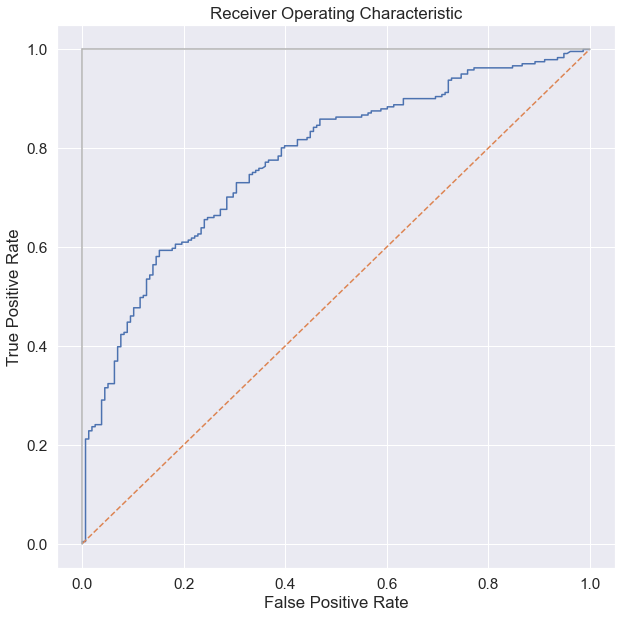

In [58]:
#Plotting the ROC curve
plt.title("Receiver Operating Characteristic")
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

In [60]:
# each observation is given an explicit probability of belonging in each class
# The first row probability is
modellr.predict_proba(X_test)[0:1]

array([[0.33476765, 0.66523235]])

In [69]:
X_test[0:1]

,OffensiveRebounds,FieldGoalPercent,GamesPlayed,Assists,PointsPerGame,FreeThrowPercent,ThreePointPercent
1287,1.1,43.7,67,0.8,3.0,61.3,0.0


In [73]:
nba_data_df.iloc[1287]

Name                  Corie Blount
GamesPlayed                     67
MinutesPlayed                 10.3
PointsPerGame                    3
FieldGoalsMade                 1.1
FieldGoalAttempts              2.6
FieldGoalPercent              43.7
ThreePointMade                   0
ThreePointAttempts               0
ThreePointPercent                0
FreeThrowMade                  0.7
FreeThrowAttempt               1.1
FreeThrowPercent              61.3
OffensiveRebounds              1.1
DefensiveRebounds              1.8
rebounds                       2.9
Assists                        0.8
Steals                         0.3
Blocks                         0.5
Turnovers                      0.8
TargetFiveYears                  1
Name: 1287, dtype: object


In [61]:
modellr.classes_

array([0, 1])

In [62]:
# the first observation has an 33% probability of being in the negative
# class (0) and a 67% chance of being in the positive class (1).
# By default, scikit-learn predicts an observation is part of the positive class if the probability 
# is greater than 0.5 (called the threshold) 
# depending on the trade offs between the true positive rate and the false positive rate
# that the business objective need we can change the threshold accordingly.

In [63]:
# The better a model is, the higher the curve and thus the greater the area under the curve.

In [64]:
# The area under the curve 
roc_auc_score(y_test, yProbs)

0.7769578234150953